# [5.2 Parameter Management](https://d2l.ai/chapter_deep-learning-computation/parameters.html)

In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.1967],
        [-0.1783]], grad_fn=<AddmmBackward>)

## 1. Parameter Access

- The [Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) class: `torch.nn.parameter.Parameter`.

In [2]:
net[2].state_dict()

OrderedDict([('weight',
              tensor([[ 0.1804, -0.3398,  0.0675, -0.1713,  0.0469, -0.3519, -0.1760, -0.3477]])),
             ('bias', tensor([0.0844]))])

In [3]:
type(net[2].bias)

torch.nn.parameter.Parameter

In [4]:
net[0].weight.shape

torch.Size([8, 4])

In [5]:
net[2].bias

Parameter containing:
tensor([0.0844], requires_grad=True)

In [6]:
# Access the tensor object stored in the net[2].bias parameter.
print(type(net[2].bias.data))
print(net[2].bias.data)

#     Another way of access the bias tensor stored in the 2nd layer of the network
print(net.state_dict()['2.bias'].data)

<class 'torch.Tensor'>
tensor([0.0844])
tensor([0.0844])


#### Access gradient

In [7]:
# access the gradient in the net[2].bias
# since we haven't run backpropagation for this network yet, it is in its initial state.
net[2].bias.grad == None

True

#### Access all parameters at once

In [8]:
# access parameters in the 1st layer of network
print(*[(name, param.shape) for name, param in net[0].named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))


In [9]:
# access parameters in the entire network
print(*[(name, param.shape) for name, param in net.named_parameters()])

('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


#### Count number of trainable parameters

In [10]:
# 4*8+8 + 8*1+1 = 49
print('TOTAL  :', sum(param.numel() for param in net.parameters() if param.requires_grad))    

TOTAL  : 49


### Collecting Parameters from Nested Blocks

In [11]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # Nested here
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.0593],
        [-0.0593]], grad_fn=<AddmmBackward>)

#### Check how the parameters are organized in the network

In [12]:
rgnet

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)

- The layers are hierarchically nested, we can also access them as though indexing through nested lists.

In [13]:
# e.g. access the 1st major block, within it the 2nd sub-block, and within that the bias of the 1st layer
rgnet[0][1][0].bias.data

tensor([ 0.4027,  0.3637,  0.0027,  0.1478, -0.4474,  0.1260,  0.2113,  0.4252])

## 2. Parameter Initialization

### Default Initialization in Pytorch

- By default, `nn.Linear` initialize parameters **uniformly** in the range (-``bound``, ``bound``), where ``bound`` = **Number of input dimensions**.
- Let's ask a wide linear layer and check : 

In [14]:
# The network would have 100x6000 parameters in stored and the weight parameter, 
#                        and 6000 parameters stored in bias.
net = nn.Linear(in_features=100, out_features=6000)

weight0 = net.weight.data.numpy()
print('weight dimension : ', weight0.shape)

bias0 = net.bias.data.numpy()
print('bias dimension : ',bias0.shape)

weight dimension :  (6000, 100)
bias dimension :  (6000,)


(array([60061., 59737., 60285., 60229., 59796., 60289., 60038., 59932.,
        59697., 59936.]),
 array([-9.9999800e-02, -7.9999834e-02, -5.9999876e-02, -3.9999913e-02,
        -1.9999951e-02,  1.1175871e-08,  1.9999973e-02,  3.9999936e-02,
         5.9999898e-02,  7.9999864e-02,  9.9999823e-02], dtype=float32),
 <a list of 10 Patch objects>)

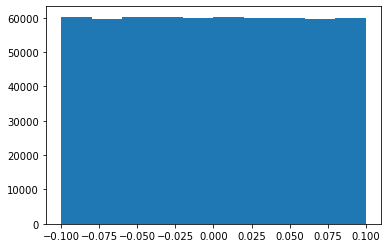

In [15]:
# By default bound = 1./sqrt(100) = 0.1
plt.hist(weight0.flatten())

(array([617., 571., 598., 597., 616., 584., 586., 600., 591., 640.]),
 array([-9.9931888e-02, -7.9940632e-02, -5.9949368e-02, -3.9958112e-02,
        -1.9966852e-02,  2.4408102e-05,  2.0015668e-02,  4.0006928e-02,
         5.9998184e-02,  7.9989448e-02,  9.9980704e-02], dtype=float32),
 <a list of 10 Patch objects>)

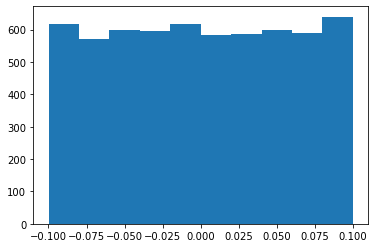

In [16]:
plt.hist(bias0.flatten())